In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import ReadDatasets
from scipy import signal
from scipy import stats
from utils import normalized_stft
from data_augmentation import TransientMaker

In [2]:
dataset = ReadDatasets()

In [3]:
gt_fids, ppm, t = dataset.read_h5_sample_track_1('../sample_data.h5')
transientmkr = TransientMaker(fids=gt_fids[:1,:,:],t=t,n_transients=160)
transientmkr.add_random_amplitude_noise(noise_level_base=6,noise_level_scan_var=2)
aug_fids = transientmkr.fids

In [4]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime

spectra_gt_fids = np.fft.fftshift(np.fft.fft(gt_fids,n=gt_fids.shape[1],axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(gt_fids.shape[1], d = dwelltime)))
#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
#not really necessary to flip to find a and b since freq and ppm agree, but we use it to enphasize the flip
#and also so np.flip(ppm)[0,idx_max] = 4.7 ppm, np.flip(ppm)[0,idx_min] = 2 ppm
#and np.flip(freq)[idx_max] = 216 Hz, and np.flip(freq)[idx_min] = -127 Hz, which agree with visual observation
a = (np.flip(ppm)[0,idx_max] - np.flip(ppm)[0,idx_min])/(np.flip(freq)[idx_max]-np.flip(freq)[idx_min])
b = np.flip(ppm)[0,idx_max] - a*np.flip(freq)[idx_max]

In [5]:
stft_coefficients_gab, freq_gab, ppm_gab, t_gab = normalized_stft(fid=np.mean(aug_fids[0,:,1,:]-aug_fids[0,:,0,:],axis=-1), fs=bandwidth, larmorfreq=127.73, window_size=256, hop_size=10, window='hann')

In [10]:
def get_normalized_spgram(fid, fs, larmorfreq, window_size, hop_size, window='hann', nfft=None):

    noverlap = window_size - hop_size
    if not signal.check_NOLA(window, window_size, noverlap):
        raise ValueError("signal windowing fails Non-zero Overlap Add (NOLA) criterion; "
                         "STFT not invertible")
    if nfft == None:
        nfft = window_size

    if window != 'hann':
        print("Warning: We are using hann window, check the function normalized_stft if you must change it")
    window_act = signal.windows.hann(window_size,sym=True)
    SFT = signal.ShortTimeFFT(
        win=window_act,
        hop=hop_size,
        fs=fs,
        mfft=nfft,
        scale_to="magnitude",
        fft_mode="centered",
    )
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fid.shape[0])

    stft_coefficients = SFT.stft(fid)
    f = np.linspace(f_lo, f_hi, nfft)
    t = np.linspace(t_lo, t_hi, stft_coefficients.shape[1])
    ppm = 4.65 + f / larmorfreq

    zero_idx = np.abs(t - 0.0).argmin()
    one_idx = np.abs(t - 1.0).argmin()
    t = t[zero_idx:one_idx]
    stft_coefficients  = stft_coefficients[:, zero_idx:one_idx]

    stft_coefficients_ordered = np.flip(stft_coefficients, axis=0)
    stft_coefficients_onesided = stft_coefficients_ordered[(ppm >= 0), :]
    #stft_coefficients_onesided = stft_coefficients[(ppm >= 0), :]
    stft_coefficients_onesided_norm = stft_coefficients_onesided / (np.max(np.abs(stft_coefficients_onesided)))

    return stft_coefficients_onesided_norm,f,ppm,t

In [11]:
mfft_ = 256
window_ = signal.windows.hann(mfft_,sym=True)
#window_ = signal.get_window('hann', mfft_)
hop_ = 10
norm_ = 'abs'
stft_coefficients_lets,freq_lets,ppm_lets,t_lets = get_normalized_spgram(fid=np.mean(aug_fids[0,:,1,:]-aug_fids[0,:,0,:],axis=-1), fs=bandwidth, larmorfreq=127.73, window_size=mfft_, hop_size=hop_, window='hann')

In [12]:
print(stft_coefficients_gab.shape)
print(stft_coefficients_lets.shape)


(204, 206)
(204, 199)


Text(0.5, 1.0, 'Real(New)')

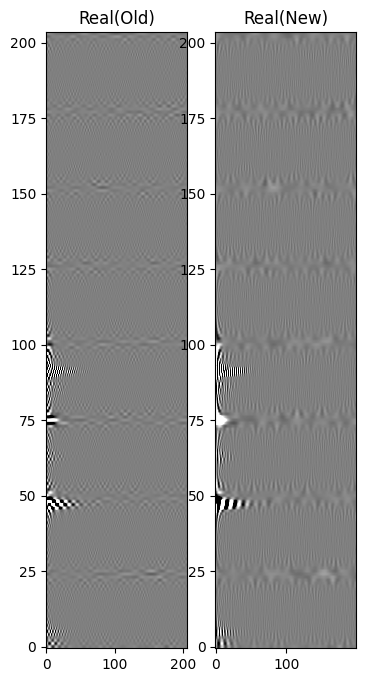

In [13]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
ax[0].imshow(np.real(stft_coefficients_gab),cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')
ax[1].imshow(np.real(stft_coefficients_lets),cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')
ax[0].set_title('Real(Old)')
ax[1].set_title('Real(New)')

(array([1.29285583e-04, 9.04999084e-04, 1.55142700e-03, 3.87856750e-03,
        5.18370547e+00, 5.36535171e-02, 3.23213959e-03, 5.17142334e-04,
        6.46427917e-04, 2.58571167e-04]),
 array([-0.93113496, -0.74060352, -0.55007207, -0.35954063, -0.16900919,
         0.02152226,  0.2120537 ,  0.40258514,  0.59311659,  0.78364803,
         0.97417947]),
 <BarContainer object of 10 artists>)

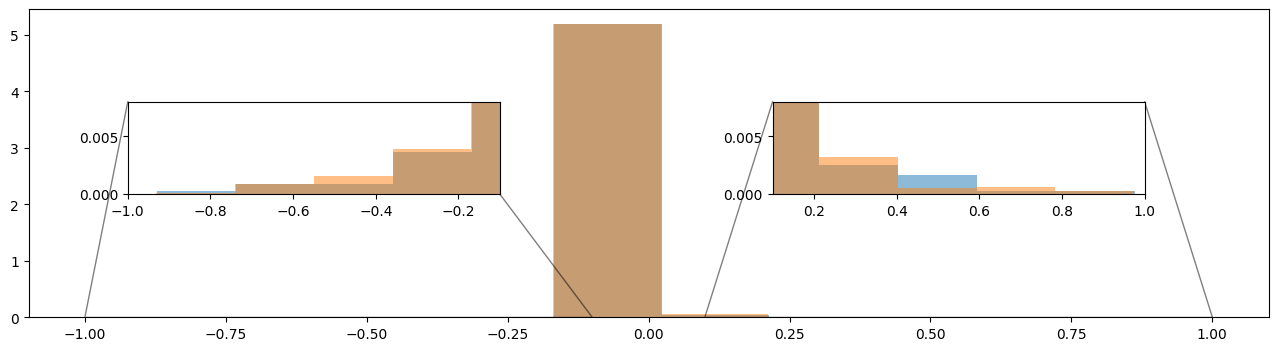

In [36]:
fig,ax = plt.subplots(1,1,figsize=(16, 4))

axins = ax.inset_axes([0.08, 0.4, 0.3, 0.3], xlim=(-1, -0.1), ylim=(0, 0.008))
axins2 = ax.inset_axes([0.6, 0.4, 0.3, 0.3], xlim=(0.1, 1), ylim=(0, 0.008))

ax.indicate_inset_zoom(axins, edgecolor="black")
ax.indicate_inset_zoom(axins2, edgecolor="black")
ax.hist(np.real(stft_coefficients_gab.flatten()),alpha=0.5,density=True)
ax.hist(np.real(stft_coefficients_lets.flatten()),alpha=0.5,density=True)
axins.hist(np.real(stft_coefficients_gab.flatten()),alpha=0.5,density=True)
axins.hist(np.real(stft_coefficients_lets.flatten()),alpha=0.5,density=True)
axins2.hist(np.real(stft_coefficients_gab.flatten()),alpha=0.5,density=True)
axins2.hist(np.real(stft_coefficients_lets.flatten()),alpha=0.5,density=True)

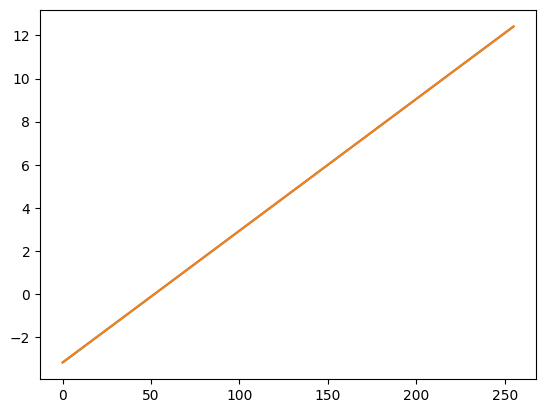

In [14]:
plt.plot(ppm_gab)
plt.plot(ppm_lets)

In [38]:
print(np.real(stft_coefficients_gab.flatten()).mean(),np.real(stft_coefficients_lets.flatten()).mean())
print(np.real(stft_coefficients_gab.flatten()).std(),np.real(stft_coefficients_lets.flatten()).std())
print(stats.skew(np.real(stft_coefficients_gab.flatten())),stats.skew(np.real(stft_coefficients_lets.flatten())))

1.7385633206567765e-06 9.956832441491664e-05
0.021161933272798094 0.02155714476999759
-0.9851593797673123 0.3984925069676298


Text(0.5, 1.0, 'Real(New)')

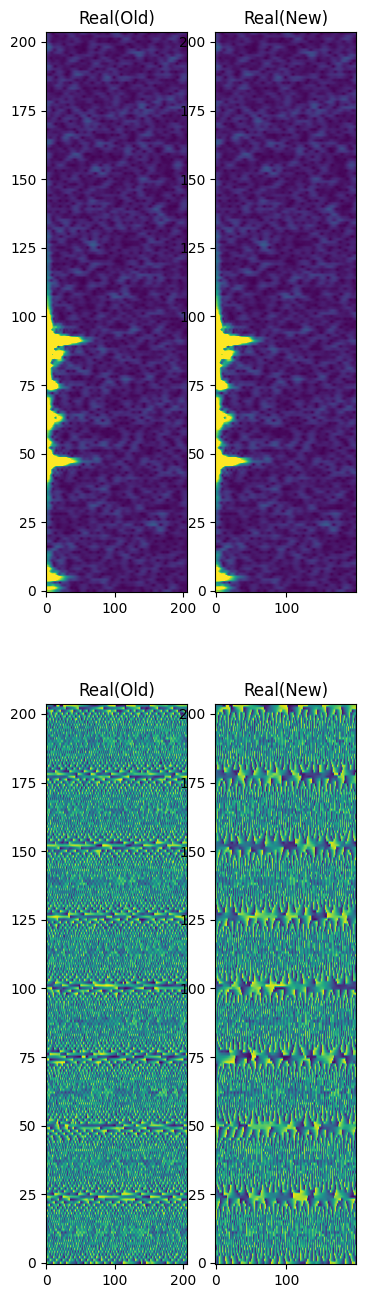

In [15]:
fig,ax = plt.subplots(2,2,figsize=(4,16))
ax[0,0].imshow(np.abs(stft_coefficients_gab),cmap='viridis',vmax=0.04,origin='lower',aspect='auto')
ax[0,1].imshow(np.abs(stft_coefficients_lets),cmap='viridis',vmax=0.04,origin='lower',aspect='auto')
ax[0,0].set_title('Real(Old)')
ax[0,1].set_title('Real(New)')
ax[1,0].imshow(np.angle(stft_coefficients_gab),cmap='viridis',origin='lower',aspect='auto')
ax[1,1].imshow(np.angle(stft_coefficients_lets),cmap='viridis',origin='lower',aspect='auto')
ax[1,0].set_title('Real(Old)')
ax[1,1].set_title('Real(New)')